# Model Evaluation
The following notebook performs measures various metrics involving the models against the provided ground-truth data.
This notebook is meant to be used as a prototype workbench for developing core code for model performance evaluation and comparison.

In our evaluation pipeline, we closely follow the result analysis performed by Gabere et. al.

In [1]:
import math
import numpy as np
import seaborn as sns
import modin.pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

Process STDOUT and STDERR is being redirected to /tmp/raylogs/.
Waiting for redis server at 127.0.0.1:61901 to respond...
Waiting for redis server at 127.0.0.1:45653 to respond...
Starting the Plasma object store with 6.00 GB memory.


In [17]:
# Application Hyperparameters
DATA_ROOT = '../data/out/data2.fasta.txt/'
# SERVERS = ['ADAM_HMM', 'ADAM_SVM', 'AMPA', 'CAMPR3-ANN', 'CAMPR3-DA', 'CAMPR3-RF', 'CAMPR3-SVM']
SERVERS = ['ADAM_HMM', 'ADAM_SVM', 'AMPA', 'CMPR3_ANN']
DATASET = ['A', 'D'] # A for AMP3 and D for DAMPD
REVERSE = ['', 'R', 'R1', 'R2', 'R3']

## Load Dataset

In [50]:
raw = pd.read_csv(DATA_ROOT + s + '.csv')

data = {}
for s in SERVERS:
    data[s] = {}
    for d in DATASET:
        data[s][d] = {}
        for r in REVERSE:
            # Append True Values
            data[s][d][r] = raw[raw.AMPLabel == 1][raw.PepID.str.contains('R') == False]
            
            # Filter Out by
            if r == '':
                data[s][d][r].append(raw[raw.AMPLabel == 0][raw.PepID.str.contains('R') == False])
            elif r == 'R':
                data[s][d][r].append(raw[raw.AMPLabel == 0][raw.PepID.str.contains('R1') == False][raw.PepID.str.contains('R2') == False][raw.PepID.str.contains('R3') == False])
            else:
                data[s][d][r].append(raw[raw.AMPLabel == 0][raw.PepID.str.contains(r)])
            
            print(s + ' ['+d+r+']' + ' : ' + str(data[s][d][r].size) + ' RECORDS')
        print('-'*30)

ADAM_HMM [A] : 13560 RECORDS
ADAM_HMM [AR] : 13560 RECORDS
ADAM_HMM [AR1] : 13560 RECORDS
ADAM_HMM [AR2] : 13560 RECORDS
ADAM_HMM [AR3] : 13560 RECORDS
------------------------------
ADAM_HMM [D] : 13560 RECORDS
ADAM_HMM [DR] : 13560 RECORDS
ADAM_HMM [DR1] : 13560 RECORDS
ADAM_HMM [DR2] : 13560 RECORDS
ADAM_HMM [DR3] : 13560 RECORDS
------------------------------
ADAM_SVM [A] : 13560 RECORDS
ADAM_SVM [AR] : 13560 RECORDS
ADAM_SVM [AR1] : 13560 RECORDS
ADAM_SVM [AR2] : 13560 RECORDS
ADAM_SVM [AR3] : 13560 RECORDS
------------------------------
ADAM_SVM [D] : 13560 RECORDS
ADAM_SVM [DR] : 13560 RECORDS
ADAM_SVM [DR1] : 13560 RECORDS
ADAM_SVM [DR2] : 13560 RECORDS
ADAM_SVM [DR3] : 13560 RECORDS
------------------------------
AMPA [A] : 13560 RECORDS
AMPA [AR] : 13560 RECORDS
AMPA [AR1] : 13560 RECORDS
AMPA [AR2] : 13560 RECORDS
AMPA [AR3] : 13560 RECORDS
------------------------------
AMPA [D] : 13560 RECORDS


The task with ID 00000000a5cfd0c47818960a3e21f61c49ed81ae is a driver task and so the object created by ray.put could not be reconstructed.
The task with ID 00000000a5cfd0c47818960a3e21f61c49ed81ae is a driver task and so the object created by ray.put could not be reconstructed.
The task with ID 00000000a5cfd0c47818960a3e21f61c49ed81ae is a driver task and so the object created by ray.put could not be reconstructed.
The task with ID 00000000a5cfd0c47818960a3e21f61c49ed81ae is a driver task and so the object created by ray.put could not be reconstructed.


AMPA [DR] : 13560 RECORDS
AMPA [DR1] : 13560 RECORDS
AMPA [DR2] : 13560 RECORDS
AMPA [DR3] : 13560 RECORDS
------------------------------
CMPR3_ANN [A] : 13560 RECORDS
CMPR3_ANN [AR] : 13560 RECORDS
CMPR3_ANN [AR1] : 13560 RECORDS
CMPR3_ANN [AR2] : 13560 RECORDS
CMPR3_ANN [AR3] : 13560 RECORDS
------------------------------
CMPR3_ANN [D] : 13560 RECORDS
CMPR3_ANN [DR] : 13560 RECORDS
CMPR3_ANN [DR1] : 13560 RECORDS
CMPR3_ANN [DR2] : 13560 RECORDS
CMPR3_ANN [DR3] : 13560 RECORDS
------------------------------


In [8]:
# Filter -999 Values
for s in SERVERS:
    for d in DATASET:
        pre_filter = data[s][d].size
        data[s][d] = data[s][d].query('PredLabel != -999')
        print(s + ' ['+d+']' + ' (POST-FILTERED): ' + str(data[s][d].size) + ' RECORDS ' + '('+ str(pre_filter - data[s][d].size) +' FILTERED)')

/usr/local/lib/python3.6/dist-packages/modin/pandas/dataframe.py:2901: UserWarning: User-defined function verification with DataFrame dtypes is still under development. Should be fully functional in a future release.
  UserWarning,


ADAM_HMM [A] (POST-FILTERED): 267168 RECORDS (60 FILTERED)
ADAM_HMM [D] (POST-FILTERED): 85068 RECORDS (234 FILTERED)
ADAM_SVM [A] (POST-FILTERED): 267192 RECORDS (36 FILTERED)
ADAM_SVM [D] (POST-FILTERED): 84954 RECORDS (348 FILTERED)
AMPA [A] (POST-FILTERED): 266508 RECORDS (720 FILTERED)
AMPA [D] (POST-FILTERED): 85044 RECORDS (258 FILTERED)
CMPR3_ANN [A] (POST-FILTERED): 266874 RECORDS (354 FILTERED)
CMPR3_ANN [D] (POST-FILTERED): 85056 RECORDS (246 FILTERED)


## Threshold Based Metrics

### Confusion Matrix

In [9]:
for s in SERVERS:
    for d in DATASET:
        print('[' + s + ' ['+d+']' + ']')
        con_mat = confusion_matrix(data[s][d]['AMPLabel'], data[s][d]['PredLabel'])
        print(str(con_mat) + '\n')
        print('True Positive:\t' + str(con_mat[0][0]))
        print('False Positive:\t' + str(con_mat[0][1]))
        print('False Negative:\t' + str(con_mat[1][0]))
        print('True Negative:\t' + str(con_mat[1][1]))
        print('='* 40)

[ADAM_HMM [A]]
[[26535 16280]
 [  155  1558]]

True Positive:	26535
False Positive:	16280
False Negative:	155
True Negative:	1558
[ADAM_HMM [D]]
[[9432 4210]
 [  74  462]]

True Positive:	9432
False Positive:	4210
False Negative:	74
True Negative:	462
[ADAM_SVM [A]]
[[26559 16260]
 [  155  1558]]

True Positive:	26559
False Positive:	16260
False Negative:	155
True Negative:	1558
[ADAM_SVM [D]]
[[9492 4139]
 [ 134  394]]

True Positive:	9492
False Positive:	4139
False Negative:	134
True Negative:	394
[AMPA [A]]
[[38507  4216]
 [ 1091   604]]

True Positive:	38507
False Positive:	4216
False Negative:	1091
True Negative:	604
[AMPA [D]]
[[11583  2048]
 [  290   253]]

True Positive:	11583
False Positive:	2048
False Negative:	290
True Negative:	253
[CMPR3_ANN [A]]
[[35626  7140]
 [  286  1427]]

True Positive:	35626
False Positive:	7140
False Negative:	286
True Negative:	1427
[CMPR3_ANN [D]]
[[11044  2596]
 [  107   429]]

True Positive:	11044
False Positive:	2596
False Negative:	107
True N

In [10]:
print('Classification Report')

for s in SERVERS:
    for d in DATASET:
        print('['+s + ' ['+d+']'+']')
        print(classification_report(data[s][d]['AMPLabel'], data[s][d]['PredLabel'], [0, 1]))
        print('='*40)

Classification Report
[ADAM_HMM [A]]
              precision    recall  f1-score   support

           0       0.99      0.62      0.76     42815
           1       0.09      0.91      0.16      1713

   micro avg       0.63      0.63      0.63     44528
   macro avg       0.54      0.76      0.46     44528
weighted avg       0.96      0.63      0.74     44528

[ADAM_HMM [D]]
              precision    recall  f1-score   support

           0       0.99      0.69      0.81     13642
           1       0.10      0.86      0.18       536

   micro avg       0.70      0.70      0.70     14178
   macro avg       0.55      0.78      0.50     14178
weighted avg       0.96      0.70      0.79     14178

[ADAM_SVM [A]]
              precision    recall  f1-score   support

           0       0.99      0.62      0.76     42819
           1       0.09      0.91      0.16      1713

   micro avg       0.63      0.63      0.63     44532
   macro avg       0.54      0.76      0.46     44532
weighte

### ROC/AUC Curve

#### Total ROC/AUC Score

In [11]:
for s in SERVERS:
    for d in DATASET:
        print(s + ' ['+d+']' + ' SCORE:\t'+str(roc_auc_score(data[s][d]['AMPLabel'], data[s][d]['PredScore'])))

ADAM_HMM [A] SCORE:	0.7646374500210282
ADAM_HMM [D] SCORE:	0.7766672611141624
ADAM_SVM [A] SCORE:	0.7648887515726709
ADAM_SVM [D] SCORE:	0.7212830102062366
AMPA [A] SCORE:	0.63368059331509
AMPA [D] SCORE:	0.6683548752011887
CMPR3_ANN [A] SCORE:	0.8330431949981598
CMPR3_ANN [D] SCORE:	0.8050252768415985


In [12]:
# Plot ROC/AUC
def plot_roc(name, d):
    plt.title(name + ' ROC')
    for s in SERVERS:
        fpr, tpr, threshold = roc_curve(data[s][d]['AMPLabel'], data[s][d]['PredScore'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label = s + ': %0.2f' % roc_auc)

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

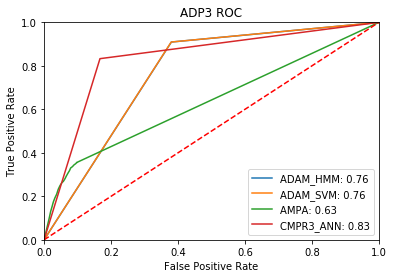

In [13]:
plot_roc('ADP3', 'A')

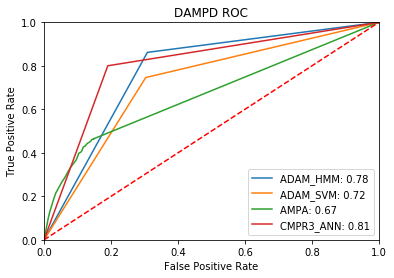

In [14]:
plot_roc('DAMPD', 'D')

## Feature Dependence Analysis

### Length vs Prediction Probability

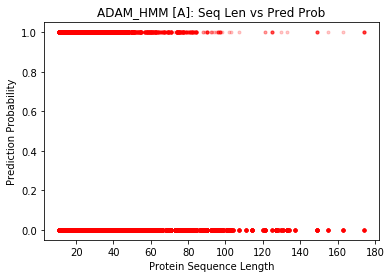

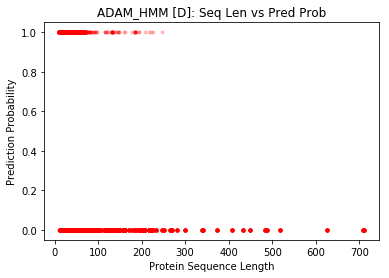

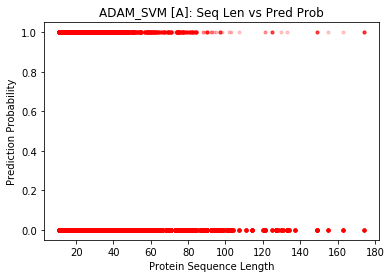

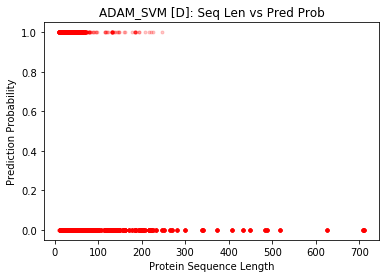

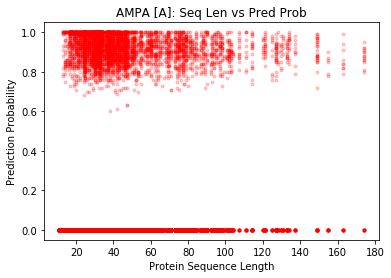

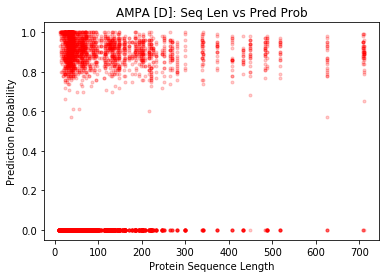

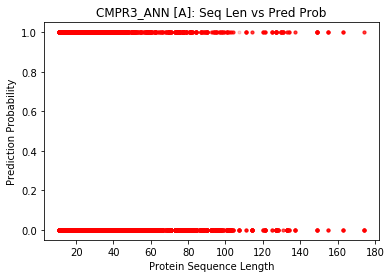

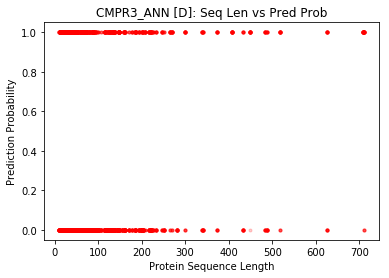

In [15]:
for s in SERVERS:
    for d in DATASET:
        plt.title(s + ' ['+d+']' + ': Seq Len vs Pred Prob')
        plt.plot(data[s][d]['PepSeq'].apply(len), data[s][d]['PredScore'], 'r.', alpha=0.2)
        plt.xlabel('Protein Sequence Length')
        plt.ylabel('Prediction Probability')
        plt.show()

### Number of Unique Protein Count vs Prediction Probability

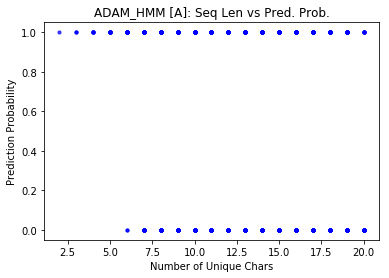

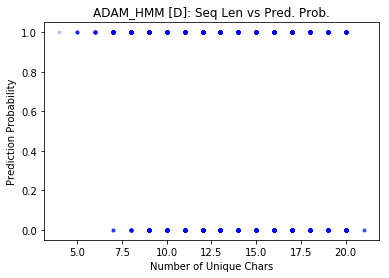

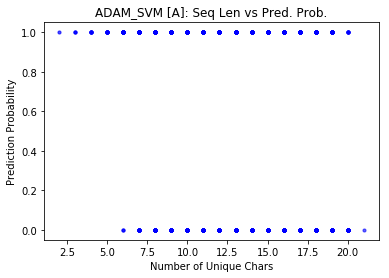

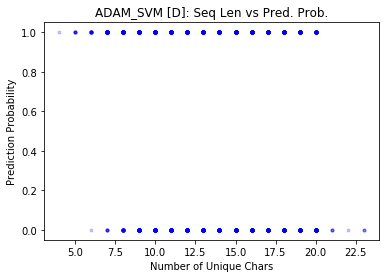

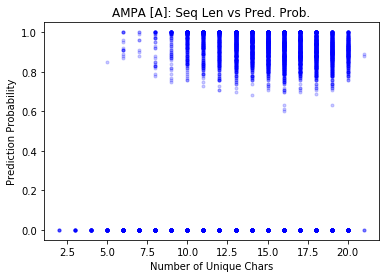

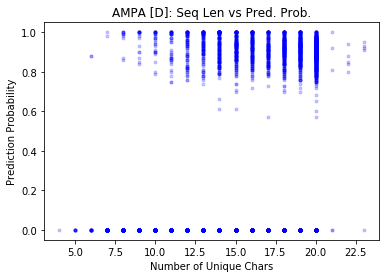

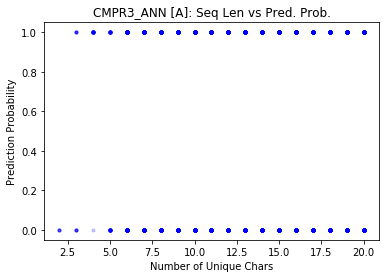

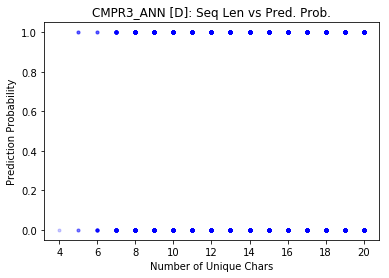

In [16]:
for s in SERVERS:
    for d in DATASET:
        plt.title(s + ' ['+d+']' + ': Seq Len vs Pred. Prob.')
        plt.plot(data[s][d]['PepSeq'].apply(lambda x: len(set(x))), data[s][d]['PredScore'], 'b.', alpha=0.2)
        plt.xlabel('Number of Unique Chars')
        plt.ylabel('Prediction Probability')
        plt.show()